In [1]:
import numpy as np
import tensorflow as tf

In [2]:
#loading the dataset from tensorflow
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
#normalising dataset between values [-1, 1]
X_train = X_train.astype('float32')
X_train = (X_train - 127.5)/127.5

X_test = X_test.astype('float32')
X_test = (X_test - 127.5)/127.5

In [4]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
#reshaping to get images as (28, 28, 1)

In [5]:
def discriminator_func():
    labels = tf.keras.layers.Input(shape=(1,))
    label_input = tf.keras.layers.Embedding(10, 50)(labels) #embedding layer to include the labels vector into the input along with images
    n_nodes = X_train.shape[1] * X_train.shape[2] #28*28 nodes
    label_input = tf.keras.layers.Dense(n_nodes)(label_input)
    label_input = tf.keras.layers.Reshape((X_train.shape[1], X_train.shape[2], 1))(label_input) #(28, 28, 1) array for labels
    input_image = tf.keras.layers.Input(shape=(28,28,1)) #(28, 28, 1) array for images
    merge = tf.keras.layers.Concatenate()([input_image, label_input]) #concatenating the image array and the labels array to make it (28,28,2) array

    #normal CNN implementation for binary classifier (as this is a discriminator)
    cnn = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    cnn = tf.keras.layers.LeakyReLU(alpha=0.2)(cnn)
    cnn = tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(cnn)
    cnn = tf.keras.layers.LeakyReLU(alpha=0.2)(cnn)
    cnn = tf.keras.layers.Flatten()(cnn)
    cnn = tf.keras.layers.Dropout(0.4)(cnn)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(cnn)

    model = tf.keras.models.Model([input_image, labels], output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
def generator_func(latent_dim):

    #creating labels and generated images arrays
    
    labels = tf.keras.layers.Input(shape=(1,))
    label_input = tf.keras.layers.Embedding(10, 50)(labels)
    n_nodes = 7 * 7
    label_input = tf.keras.layers.Dense(n_nodes)(label_input)
    label_input = tf.keras.layers.Reshape((7,7,1))(label_input) #by this definition, it will be easier to upsample to (28,28,1) shape of image
    input_latent = tf.keras.layers.Input(shape=(latent_dim,))

    n_nodes = 7 * 7 * 128
    gen = tf.keras.layers.Dense(n_nodes)(input_latent)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Reshape((7, 7, 128))(gen)

    merge = tf.keras.layers.Concatenate()([gen, label_input]) #merging the two arrays of generated image and labels

    #upsampling to (28,28,1)
    
    gen = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(1,1), padding='same')(merge)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
    gen = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

    output_layer = tf.keras.layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    model = tf.keras.models.Model([input_latent, labels], output_layer)
    return model

In [7]:
def gan_func(generator_model, discriminator_model):
    #we are training discriminator separately
    discriminator_model.trainable = False 

    #defining inputs and outputs variables
    gen_noise, gen_labels = generator_model.input
    gen_output = generator_model.output

    gan_output = discriminator_model([gen_output, gen_labels])

    #defining a model on the basis of the given inputs and outputs
    model = tf.keras.models.Model([gen_noise, gen_labels], gan_output)

    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [8]:
def train(generator_model, discriminator_model, gan_model, dataset, latent_dim, epochs=100, batch_size=128):
    batch_per_epoch = int(dataset[0].shape[0]/batch_size) #total/batchsize
    half_batch = int(batch_size/2)
    for i in range(epochs):
        for j in range(batch_per_epoch):

            #defining variables for generated fake and real samples and defining their losses
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            discriminator_loss1, _ = discriminator_model.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels], y_fake = generate_fake_samples(generator_model, latent_dim, half_batch)
            discriminator_loss2, _ = discriminator_model.train_on_batch([X_fake, labels], y_fake)

            [z_input, labels_input] = generate_latent_points(latent_dim, batch_size)
            y_gan = np.ones((batch_size, 1))

            generator_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            print(f'Epoch: {i+1}, Batch: {j+1}/{batch_per_epoch}, discriminator loss real = {discriminator_loss1}, disciminator loss fake = {discriminator_loss2}, generator loss = {generator_loss}')
        generator_model.save('mnist_conditional_generator.h5')

In [9]:
def load_real_samples():
    #load dataset as list of 2 arrays
    return [X_train, y_train]

In [10]:
def generate_real_samples(dataset, samples):
    #returning real inputs and outputs
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], samples)
    X, labels = images[ix], labels[ix]

    y = np.ones((samples, 1))
    return [X, labels], y

In [11]:
def generate_latent_points(latent_dim, samples):
    
    X_input = np.random.randn(latent_dim * samples)
    Z_input = X_input.reshape(samples, latent_dim)

    labels = np.random.randint(0, 10, samples)
    return [Z_input, labels]
    

In [12]:
def generate_fake_samples(generator, latent_dim, samples):
    #returning fake inputs and outputs
    Z_input, labels_input = generate_latent_points(latent_dim, samples)

    images = generator.predict([Z_input, labels_input])

    y = np.zeros((samples, 1))
    return [images, labels_input], y

In [13]:
#calling required functions

latent_dim = 100
d_model = discriminator_func()
g_model = generator_func(latent_dim)
gan_model = gan_func(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim, epochs=250)

2/2 [==============================] - 0s 48ms/step
Epoch: 1, Batch: 1/468, discriminator loss real = 0.6881901025772095, disciminator loss fake = 0.7026859521865845, generator loss = 0.6864200830459595
2/2 [==============================] - 0s 43ms/step
Epoch: 1, Batch: 2/468, discriminator loss real = 0.32550129294395447, disciminator loss fake = 0.8217029571533203, generator loss = 0.5725339651107788
2/2 [==============================] - 0s 39ms/step
Epoch: 1, Batch: 3/468, discriminator loss real = 0.13367541134357452, disciminator loss fake = 1.287941575050354, generator loss = 0.3841692805290222
2/2 [==============================] - 0s 35ms/step
Epoch: 1, Batch: 4/468, discriminator loss real = 0.08931335806846619, disciminator loss fake = 1.6488834619522095, generator loss = 0.3252536952495575
2/2 [==============================] - 0s 40ms/step
Epoch: 1, Batch: 5/468, discriminator loss real = 0.12093643844127655, disciminator loss fake = 1.2530646324157715, generator loss = 0

C:\Users\DHRUVA\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 58ms/step
Epoch: 2, Batch: 1/468, discriminator loss real = 1.977135261066465e-10, disciminator loss fake = 5.124264134792611e-05, generator loss = 10.15060806274414
2/2 [==============================] - 0s 38ms/step
Epoch: 2, Batch: 2/468, discriminator loss real = 8.522993075188445e-12, disciminator loss fake = 5.19503046234604e-05, generator loss = 10.232269287109375
2/2 [==============================] - 0s 41ms/step
Epoch: 2, Batch: 3/468, discriminator loss real = 1.298683161010672e-09, disciminator loss fake = 5.10554455104284e-05, generator loss = 10.319881439208984
2/2 [==============================] - 0s 61ms/step
Epoch: 2, Batch: 4/468, discriminator loss real = 6.272408703544841e-10, disciminator loss fake = 4.883181827608496e-05, generator loss = 10.349138259887695
2/2 [==============================] - 0s 43ms/step
Epoch: 2, Batch: 5/468, discriminator loss real = 1.8052864447781758e-07, disciminator loss fake = 3.72088179574348


KeyboardInterrupt



4/4 [==============================] - 3s 86ms/step


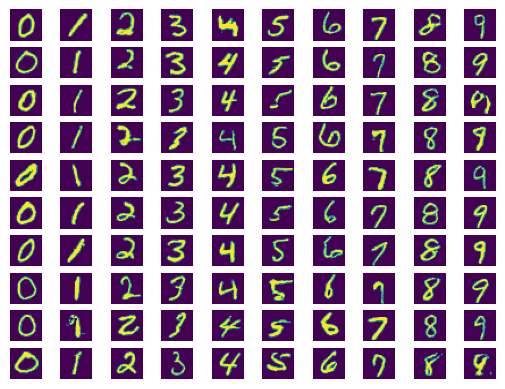

In [20]:
#displaying conditioned images 
import matplotlib.pyplot as plt
model = tf.keras.models.load_model('mnist_conditional_generator.h5', compile=False)

latent_points, labels = generate_latent_points(100, 100)

labels = np.asarray([x for _ in range(10) for x in range(10)])

X = model.predict([latent_points, labels])

X = (X+1)/2.0
X = (X*255).astype(np.uint8)

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    plt.imshow(X[i, :,:,:])
plt.show()